## Multioutput model (with context)

Now, we need a model to detect the type of hate

In [1]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets

train_dataset, dev_dataset, test_dataset = load_datasets()


Let's take just the comments that are HATEFUL

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_dataset = train_dataset.filter(lambda x: x["HATEFUL"] > 0)
dev_dataset = dev_dataset.filter(lambda x: x["HATEFUL"] > 0)
test_dataset = test_dataset.filter(lambda x: x["HATEFUL"] > 0)


## Clasificación

Usamos nuestro modelo `hatedetection.BertForSequenceMultiClassification`. Es una leve modificación del clasificador de `transformers`

In [3]:
from transformers import AutoTokenizer
from hatedetection import BertForSequenceMultiClassification, extended_hate_categories

model_name = "../models/bert-contextualized-hate-category-es/"

model = BertForSequenceMultiClassification.from_pretrained(
    model_name,
    return_dict=True, num_labels=len(extended_hate_categories)
)

model.eval();
tokenizer = AutoTokenizer.from_pretrained(model_name)
#
tokenizer.model_max_length = 256

In [4]:
def tokenize(batch, context=True, padding='max_length', truncation=True):
    """
    Apply tokenization
    
    Arguments:
    ---------
    
    use_context: boolean (default True)
        Whether to add the context to the 
    """
    
    if context:
        args = [batch['context'], batch['text']]
    else:
        args = [batch['text']]
        
    return tokenizer(*args, padding='max_length', truncation=True)

batch_size = 32
eval_batch_size = 16

my_tokenize = lambda x: tokenize(x, context=True)

train_dataset = train_dataset.map(my_tokenize, batched=True, batch_size=batch_size)
dev_dataset = dev_dataset.map(my_tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(my_tokenize, batched=True, batch_size=eval_batch_size)



In [5]:
import torch
def format_dataset(dataset):
    def get_category_labels(examples):
        return {'labels': torch.Tensor([examples[cat] for cat in extended_hate_categories])}
    dataset = dataset.map(get_category_labels)
    dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
    return dataset

train_dataset = format_dataset(train_dataset)
dev_dataset = format_dataset(dev_dataset)
test_dataset = format_dataset(test_dataset)


Esta API de mierda vive cambiando todo el tiempo

In [6]:
from hatedetection.metrics import compute_category_metrics
from transformers import Trainer, TrainingArguments



training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    evaluation_strategy="epoch",
    do_eval=False,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

results = []

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_category_metrics,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)

In [7]:
import pandas as pd
pd.options.display.max_columns = 40
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df_results = pd.DataFrame([trainer.evaluate(dev_dataset)])

df_results.T

,0
eval_loss,0.11481
eval_calls_f1,0.90134
eval_women_f1,0.89698
eval_lgbti_f1,0.93648
eval_racism_f1,0.96321
eval_class_f1,0.90073
eval_politics_f1,0.90122
eval_disabled_f1,0.87398
eval_appearance_f1,0.93343
eval_criminal_f1,0.97199


## Error Analysis

In [10]:
pred_output = trainer.predict(dev_dataset)

pred_output.predictions.shape

(1387, 9)

In [12]:
from datasets import ClassLabel
from hatedetection import extended_hate_categories


dev_df = dev_dataset.to_pandas()
dev_df.set_index("id", inplace=True)
PAD_IDX = tokenizer.vocab["[PAD]"]

def decode(example):
    """
    Returns what the BERT models get as input
    """
    input_ids = [x.item() for x in example["input_ids"] if x.item() != PAD_IDX]
    return tokenizer.decode(input_ids)




dev_df["tokenized_text"] = dev_df.apply(decode, axis=1)
dev_df = dev_df[["text", "context", "tokenized_text"] + extended_hate_categories]


for i, cat in enumerate(extended_hate_categories):
    dev_df["pred_"+cat] = (pred_output.predictions[:, i] > 0).round().astype(int)
dev_df

,text,context,tokenized_text,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL,pred_CALLS,pred_WOMEN,pred_LGBTI,pred_RACISM,pred_CLASS,pred_POLITICS,pred_DISABLED,pred_APPEARANCE,pred_CRIMINAL
id,,,,,,,,,,,,,,,,,,,,,
367342,usuario La poca sociedad que trabaja bancar a ...,IFE: el Gobierno analiza mantener el bono de $...,[CLS] IFE : el Gobierno analiza mantener el bo...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
369361,"usuario y con el palo en la mano,no podía fall...","El abuelo que a los 90 años confesó: “Soy gay,...",[CLS] El abuelo que a los 90 años confesó : [U...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
340127,usuario usuario Otro chileno awueonao a la ...,Tosió y estornudó sobre periodista de Crónica ...,[CLS] Tosió y estornudó sobre periodista de Cr...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
357470,usuario Que gordo sorete!! Tiene que ser kirne...,"Roberto Baradel criticó que se intenten ""forza...",[CLS] Roberto Baradel criticó que se intenten ...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
352418,usuario Malayos chinos de mierda. Jodieron al ...,Coronavirus: China prohíbe criar perros para c...,[CLS] Coronavirus : China prohíbe criar perros...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328535,usuario Bala? Hasta cuándo vamos a ser buenitos?,Coronavirus en Argentina: interceptan en un mi...,[CLS] Coronavirus en Argentina : interceptan e...,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
358560,usuario Mira vos al zurdo roñoso amenazando co...,La advertencia de Juan Grabois: “Hay una olead...,[CLS] La advertencia de Juan Grabois : [UNK] H...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
399006,usuario usuario usuario SOS la peor mierda de ...,Fuerte cruce entre Flavio Mendoza y Victoria D...,[CLS] Fuerte cruce entre Flavio Mendoza y Vict...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## CALLS

<AxesSubplot:ylabel='index'>

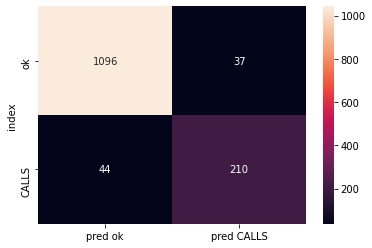

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cat = "CALLS"
pred_cat = "pred_" + cat

cm = pd.DataFrame(
    confusion_matrix(dev_df[cat], dev_df[pred_cat])
)

cm.columns = ["pred ok", "pred "+cat]

cm["index"] = ["ok", cat]

cm.set_index("index", inplace=True)

normalized = cm
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)


false_negatives = dev_df.loc[((~dev_df[pred_cat]) & (dev_df[cat])) != 0]

false_positives = dev_df.loc[((dev_df[pred_cat]) & (~dev_df[cat])) != 0]

columns = ["text", "context", "tokenized_text"] + [pred_cat, cat]
false_negatives = false_negatives[columns]
false_positives = false_positives[columns]

sns.heatmap(normalized, annot=cm, fmt="", robust=True)

In [16]:
pd.options.display.max_colwidth = 500
false_negatives.sample(10)

,text,context,tokenized_text,pred_CALLS,CALLS
id,,,,,
341715,usuario que podria pasar??? hacemos un asado para festejar eso pasaria!,Qué podría pasar si el coronavirus llega a las hacinadas cárceles bonaerenses,[CLS] Qué podría pasar si el coronavirus llega a las hacinadas cárceles bonaerenses [SEP] usuario que podria pasar??? hacemos un asado para festejar eso pasaria! [SEP],0,1
328539,usuario #enchelon a la mierda.a su pais chinos come mugre 🤮,Coronavirus en Argentina: interceptan en un micro a dos chinos que no cumplieron la cuarentena,[CLS] Coronavirus en Argentina : interceptan en un micro a dos chinos que no cumplieron la cuarentena [SEP] usuario [UNK] enchelon a la mierda. a su pais chinos come mugre [UNK] [SEP],0,1
376797,usuario La solución 👈➡️💣💥🇨🇳,Aparecen casos de peste bubónica en China,[CLS] Aparecen casos de peste bubónica en China [SEP] usuario La solución [UNK] [SEP],0,1
353040,"usuario Basicamente no quieren laborar y que les paguen más por eso. El día que entiendan TODOS que hay que eliminarlos, este país sale adelante.",El Polo Obrero realiza un corte en la Panamericana en contra de la flexibilización de la cuarentena y en reclamo de aumentos a los planes sociales,"[CLS] El Polo Obrero realiza un corte en la Panamericana en contra de la flexibilización de la cuarentena y en reclamo de aumentos a los planes sociales [SEP] usuario Basicamente no quieren laborar y que les paguen más por eso. El día que entiendan TODOS que hay que eliminarlos, este país sale adelante. [SEP]",0,1
345445,"usuario Estas personas son asesinos,chorros,violadores,felicidad y narcos....en síntesis son una peste de la sociedad...ojalá el coronavirus haga justicia,esa justicia que muchos de los familiares de esas víctimas que fueron asesinadas por cada uno de estos HdP...",Coronavirus en Argentina: se levantó la protesta de los presos en la cárcel de Melchor Romero,"[CLS] Coronavirus en Argentina : se levantó la protesta de los presos en la cárcel de Melchor Romero [SEP] usuario Estas personas son asesinos, chorros, violadores, felicidad y narcos.... en síntesis son una peste de la sociedad... ojalá el coronavirus haga justicia, esa justicia que muchos de los familiares de esas víctimas que fueron asesinadas por cada uno de estos HdP... [SEP]",0,1
376817,usuario usuario BOMBARDEÁ usuario,Aparecen casos de peste bubónica en China,[CLS] Aparecen casos de peste bubónica en China [SEP] usuario usuario BOMBARDEÁ usuario [SEP],0,1
394354,"usuario TENEMOS QUE LIMPIAR LA ROSADA!!!!!,HAY MUCHA MIERDA CRECIENDO ,,COMO DECÍAN MIS CAMADAS,SON BROTES SUBERSIVOS Y HAY QUE ELIMINARLOS ☠️☠️☠️","Quién es Sabino Vaca Narvaja, el hijo de un fundador de Montoneros que se hará cargo de la Embajada en China","[CLS] Quién es Sabino Vaca Narvaja, el hijo de un fundador de Montoneros que se hará cargo de la Embajada en China [SEP] usuario TENEMOS QUE LIMPIAR LA ROSADA!!!!!, HAY MUCHA MIERDA CRECIENDO,, COMO DECÍAN MIS CAMADAS, SON BROTES SUBERSIVOS Y HAY QUE ELIMINARLOS [UNK] [SEP]",0,1
366338,usuario Pum! Pum! Pum! Pum! Pum! Ya que van al cementerio que sigan todos juntitos,El polémico cortejo fúnebre de los barras de Quilmes para despedir al ladrón baleado por el jubilado,[CLS] El polémico cortejo fúnebre de los barras de Quilmes para despedir al ladrón baleado por el jubilado [SEP] usuario Pum! Pum! Pum! Pum! Pum! Ya que van al cementerio que sigan todos juntitos [SEP],0,1
388621,usuario Y no lo lincharon todavía,"“Los padres confían en mí, ese es su problema”: los espeluznantes mensajes de un docente de una escuela evangélica en los que admite que abusó de menores","[CLS] [UNK] Los padres confían en mí, ese es su problema [UNK] : los espeluznantes mensajes de un docente de una escuela evangélica en los que admite que abusó de menores [SEP] usuario Y no lo lincharon todavía [SEP]",0,1


## LGBTI

<AxesSubplot:ylabel='index'>

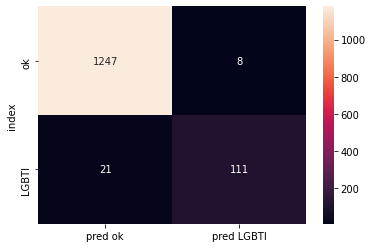

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cat = "LGBTI"
pred_cat = "pred_" + cat

cm = pd.DataFrame(
    confusion_matrix(dev_df[cat], dev_df[pred_cat])
)

cm.columns = ["pred ok", "pred "+cat]

cm["index"] = ["ok", cat]

cm.set_index("index", inplace=True)

normalized = cm
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)


false_negatives = dev_df.loc[((~dev_df[pred_cat]) & (dev_df[cat])) != 0]

false_positives = dev_df.loc[((dev_df[pred_cat]) & (~dev_df[cat])) != 0]

columns = ["text", "context", "tokenized_text"] + [pred_cat, cat]
false_negatives = false_negatives[columns]
false_positives = false_positives[columns]

sns.heatmap(normalized, annot=cm, fmt="", robust=True)

In [18]:
false_negatives

,text,context,tokenized_text,pred_LGBTI,LGBTI
id,,,,,
356866,"usuario Inclusión social es incluir a tos por igual no solo a los HOMBRES DISFRAZADOS DE MUJERES, inclusión es el derecho a la vida, a estudiar, a los sordos, ciegos y mudos, autistas y podría seguir, mirá en qué se enfocan éstos miserables del gobierno y encima con nuestros impuestos.",Fabiola Yáñez encabezó una reunión virtual con 459 gerentes del Banco Nación y los instó a trabajar por la inclusión social,"[CLS] Fabiola Yáñez encabezó una reunión virtual con 459 gerentes del Banco Nación y los instó a trabajar por la inclusión social [SEP] usuario Inclusión social es incluir a tos por igual no solo a los HOMBRES DISFRAZADOS DE MUJERES, inclusión es el derecho a la vida, a estudiar, a los sordos, ciegos y mudos, autistas y podría seguir, mirá en qué se enfocan éstos miserables del gobierno y encima con nuestros impuestos. [SEP]",0,1
336373,"usuario Capaz si te ponías , el negro arrepentido q se tiñò de rubio, y encima es peronista..quizás tenías éxito... ☝️🤷🤪👀👀","La angustia de La Rubia Peronista por la crisis: “Estoy en un momento complicado, hago shows virtuales a la gorra”","[CLS] La angustia de La Rubia Peronista por la crisis : [UNK] Estoy en un momento complicado, hago shows virtuales a la gorra [UNK] [SEP] usuario Capaz si te ponías, el negro arrepentido q se [UNK] de rubio, y encima es peronista.. quizás tenías éxito... [UNK] [SEP]",0,1
384518,usuario usuario usuario usuario AL PARÁSITO SOCIAL DE CAFIERO CHUPALA PUTO,"Santiago Cafiero repudió el ataque a C5N: ""Hay que desarmar el discurso del odio""","[CLS] Santiago Cafiero repudió el ataque a C5N : "" Hay que desarmar el discurso del odio "" [SEP] usuario usuario usuario usuario AL PARÁSITO SOCIAL DE CAFIERO CHUPALA PUTO [SEP]",0,1
367114,usuario Maraca peroncho arrepentido,"Negro Oro: “El día que se pueda, me voy a Uruguay hasta que pase todo”","[CLS] Negro Oro : [UNK] El día que se pueda, me voy a Uruguay hasta que pase todo [UNK] [SEP] usuario Maraca peroncho arrepentido [SEP]",0,1
348741,"usuario No no no boliviano puto, no te confundas, como anillo al dedo le viene a los zurdos que pieden meter la mano en la lata teniéndonos de rehenes sin poder hacer nada.\nYa se te va a terminar la buena vida sorete.",Evo Morales: “La pandemia cae como anillo a dedo para los gobiernos de derecha”,"[CLS] Evo Morales : [UNK] La pandemia cae como anillo a dedo para los gobiernos de derecha [UNK] [SEP] usuario No no no boliviano puto, no te confundas, como anillo al dedo le viene a los zurdos que pieden meter la mano en la lata teniéndonos de rehenes sin poder hacer nada. Ya se te va a terminar la buena vida sorete. [SEP]",0,1
334744,"usuario No te hace falta mucho, con un solo corte lo sos",Jimena Barón y una profunda reflexión: “Si fuera hombre sería alto macho”,"[CLS] Jimena Barón y una profunda reflexión : [UNK] Si fuera hombre sería alto macho [UNK] [SEP] usuario No te hace falta mucho, con un solo corte lo sos [SEP]",0,1
355562,"usuario BRANDONI RECORRIO TODO EL ARCO POLITICO!!!EMPEZO COMO SECRETARIO DE ACTORES Y DE IZQUIERDA CON ALFONSIN SE HIZO DE CENTRO CON EL ANTIGUO RADICALISMO, Y AHORA DE EXTREMA DERECHA CON SUS CAMARADAS NAZIS!!!!ESTA UN POCO CON ALZHEIMER!!!VIEJO PUTO!!YA NO PUEDE CRUZAR NI LA CALLE!!!","Luis Brandoni cruzó a Ricardo Alfonsín por sus críticas a la marcha: “No está en el centro de sus convicciones, de lo que ha mamado desde que nació”","[CLS] Luis Brandoni cruzó a Ricardo Alfonsín por sus críticas a la marcha : [UNK] No está en el centro de sus convicciones, de lo que ha mamado desde que nació [UNK] [SEP] usuario BRANDONI RECORRIO TODO EL ARCO POLITICO!!! EMPEZO COMO SECRETARIO DE ACTORES Y DE IZQUIERDA CON ALFONSIN SE HIZO DE CENTRO CON EL ANTIGUO RADICALISMO, Y AHORA DE EXTREMA DERECHA CON SUS CAMARADAS NAZIS!!!! ESTA UN POCO CON ALZHEIMER!!! VIEJO PUTO!! YA NO PUEDE CRUZAR NI LA CALLE!!! [SEP]",0,1
392319,usuario China se va a llenar de Putos haciendo Turismo...,La prueba anal de coron

In [19]:
false_positives

,text,context,tokenized_text,pred_LGBTI,LGBTI
id,,,,,
333926,usuario Nefasta porrera!,"Calu Rivero, desnuda en una playa de Estados Unidos, reflexionó sobre la libertad y el empoderamiento de las mujeres a través del arte","[CLS] Calu Rivero, desnuda en una playa de Estados Unidos, reflexionó sobre la libertad y el empoderamiento de las mujeres a través del arte [SEP] usuario Nefasta porrera! [SEP]",1,0
373764,"usuario En mi barrio le dicen trol4, cornuda conciente 😊","Empezó con una “relación abierta en lo sexual”, escaló al poliamor y da las claves para probar el amor libre","[CLS] Empezó con una [UNK] relación abierta en lo sexual [UNK], escaló al poliamor y da las claves para probar el amor libre [SEP] usuario En mi barrio le dicen trol4, cornuda conciente [UNK] [SEP]",1,0
333885,usuario Más fafafa x favor,"Calu Rivero, desnuda en una playa de Estados Unidos, reflexionó sobre la libertad y el empoderamiento de las mujeres a través del arte","[CLS] Calu Rivero, desnuda en una playa de Estados Unidos, reflexionó sobre la libertad y el empoderamiento de las mujeres a través del arte [SEP] usuario Más fafafa x favor [SEP]",1,0
392573,usuario VOS DECIS Q LOS GORILAS PAGOS NO SE VACUNAN????,Coronavirus: Luis Novaresio contó cuál es su condición para aplicarse la vacuna rusa Sputnik V,[CLS] Coronavirus : Luis Novaresio contó cuál es su condición para aplicarse la vacuna rusa Sputnik V [SEP] usuario VOS DECIS Q LOS GORILAS PAGOS NO SE VACUNAN???? [SEP],1,0
350301,usuario Ya esta llorando el simio maricon. Sucio pedorro!,El líder piquetero Luis D’Elía pidió el indulto presidencial,[CLS] El líder piquetero Luis D [UNK] Elía pidió el indulto presidencial [SEP] usuario Ya esta llorando el simio maricon. Sucio pedorro! [SEP],1,0
345966,usuario Que manera de romper las pelotas estos orcos con peinado de astroboy,Aborto: militantes feministas aseguran que cuando pase el coronavirus se tratará el proyecto y será ley,[CLS] Aborto : militantes feministas aseguran que cuando pase el coronavirus se tratará el proyecto y será ley [SEP] usuario Que manera de romper las pelotas estos orcos con peinado de astroboy [SEP],1,0
403116,usuario lo que hace el Paco!,Se implantó dos aletas en el cráneo para experimentar nuevos sentidos: “No me considero 100% humano”,[CLS] Se implantó dos aletas en el cráneo para experimentar nuevos sentidos : [UNK] No me considero 100 [UNK] humano [UNK] [SEP] usuario lo que hace el Paco! [SEP],1,0
333897,usuario Que culo fiero ! 😂😂😂😂😂😂🙏😷🙏🙏🙏🤔,"Calu Rivero, desnuda en una playa de Estados Unidos, reflexionó sobre la libertad y el empoderamiento de las mujeres a través del arte","[CLS] Calu Rivero, desnuda en una playa de Estados Unidos, reflexionó sobre la libertad y el empoderamiento de las mujeres a través del arte [SEP] usuario Que culo fiero! [UNK] [SEP]",1,0


## Probing

In [8]:
from hatedetection.predict import predict_category

def predict(sentence, context=None):
    return predict_category(model, tokenizer, sentence, context=context)

In [9]:


context = "Motín de presos en la cárcel de Devoto"

comments = [
    "Negro chorro de mierda",
    "Este país está lleno de vagos",
    "Cuarenta ladrillos y esto se arregla...",
    "Bala",
    "Videla volvé!",
    "Ahhhn y donde estan las feministas de mierda eh?",
    "Y qué van a decir los chinos sobre este desastre?",
]

for comment in comments:
    print(comment)
    prediction = predict(comment, context=context)
    print(prediction)

Negro chorro de mierda
['RACISM', 'CRIMINAL']
Este país está lleno de vagos
['CRIMINAL']
Cuarenta ladrillos y esto se arregla...
['CRIMINAL']
Bala
['CRIMINAL']
Videla volvé!
['CRIMINAL']
Ahhhn y donde estan las feministas de mierda eh?
['WOMEN']
Y qué van a decir los chinos sobre este desastre?
['RACISM']


In [10]:
context="Florencia Peña dio una entrevista a Infobae"

comments = [
    "Corrupta",
    "Callate petera",
    "Gato viejo",
    "Quiere bijaaa",
    "Toda cirujeada esta",
    "Estás gordita mamu",
    "Che y de los chinos come murcielagos no tenés nada para decir?",
]

for comment in comments:
    print(comment)
    prediction = predict(comment, context=context)
    print(prediction)



Corrupta
['WOMEN']
Callate petera
['WOMEN']
Gato viejo
['WOMEN', 'APPEARANCE']
Quiere bijaaa
['WOMEN']
Toda cirujeada esta
['WOMEN']
Estás gordita mamu
['WOMEN', 'APPEARANCE']
Che y de los chinos come murcielagos no tenés nada para decir?
['RACISM']


In [11]:
context="Cristina Fernández de Kirchner inaugura una obra en Tierra del Fuego"

comments = [
    "Soreta",
    "Callate petera",
    "Gato viejo",
    "Toda cirujeada esta",
    "Estás gordita mamu",
    "Che y de los chinos come murcielagos no tenés nada para decir?",
]

for comment in comments:
    print(comment)
    prediction = predict(comment, context=context)
    print(prediction)



Soreta
['DISABLED']
Callate petera
[]
Gato viejo
['APPEARANCE']
Toda cirujeada esta
['APPEARANCE']
Estás gordita mamu
['APPEARANCE']
Che y de los chinos come murcielagos no tenés nada para decir?
['RACISM']


In [12]:
context="Juan y Fernando Pérez se casarán por civil durante la pandemia"

comments = [
    "Ay pero qué asco",
    "Viejos putos",
    "Trolos roñosos",
    "Desviados!",
    "Hay que mandarlos a una isla en el medio del oceano a estos pervertidos",
    "Basta de topus, coronavirus, chinos y Soros",
    "Che y las feminazis hijas de puta no tienen nada para decir de esto?",
    "Pero qué asco por favor",
    "Puedo vomitar?",
    "Jajaja no seas trolo Raúl",
    "Asco",
    "Esta gente no teme a Dios"
]

print("Noticia:")
print(context, "\n"*3)

print("Comentarios")
for comment in comments:
    print(comment)
    prediction = predict(comment, context=context)
    print(prediction)



Noticia:
Juan y Fernando Pérez se casarán por civil durante la pandemia 



Comentarios
Ay pero qué asco
['WOMEN']
Viejos putos
['LGBTI', 'APPEARANCE']
Trolos roñosos
['LGBTI', 'APPEARANCE']
Desviados!
['WOMEN']
Hay que mandarlos a una isla en el medio del oceano a estos pervertidos
['CALLS']
Basta de topus, coronavirus, chinos y Soros
['RACISM']
Che y las feminazis hijas de puta no tienen nada para decir de esto?
['WOMEN']
Pero qué asco por favor
['WOMEN']
Puedo vomitar?
['WOMEN']
Jajaja no seas trolo Raúl
['LGBTI']
Asco
['WOMEN', 'LGBTI']
Esta gente no teme a Dios
['WOMEN']


In [13]:
predict("Quiere bijaaa", context="Florencia Peña dio una entrevista a Infobae")

['WOMEN']

In [14]:
context="Cristiano Ronaldo metió su gol número 812 y es el mayor goleador de la historia"

comments = [
    "Asco",
    "Esta gente no teme a Dios",
    "A este Cristiano le gusta el sable",
    "Se sentó encima de la pelota?",
    "Es más uto este Cristiano"
]

print("Noticia:")
print(context, "\n"*3)

print("Comentarios")
for comment in comments:
    print(comment)
    prediction = predict(comment, context=context)
    print(prediction)



Noticia:
Cristiano Ronaldo metió su gol número 812 y es el mayor goleador de la historia 



Comentarios
Asco
['LGBTI']
Esta gente no teme a Dios
[]
A este Cristiano le gusta el sable
['LGBTI']
Se sentó encima de la pelota?
['LGBTI']
Es más uto este Cristiano
['LGBTI']


In [15]:
context="Romina C, una chica trans, nos cuenta sus vacaciones en Cancún"

comments = [
    "Asco",
    "Esta gente no teme a Dios",
    "Me parece que se llama Romino",
    "Es un camionero!",
    "Esta tal Romina que muestre el documento",
    "Romina es un flor de travesti",
    "Habría que ver si viene con paquete la tal Romina",
    "Romina es macho",
]

print("Noticia:")
print(context, "\n"*3)

print("Comentarios")
for comment in comments:
    print(comment)
    prediction = predict(comment, context=context)
    print(prediction)



Noticia:
Romina C, una chica trans, nos cuenta sus vacaciones en Cancún 



Comentarios
Asco
['LGBTI']
Esta gente no teme a Dios
['LGBTI']
Me parece que se llama Romino
['LGBTI']
Es un camionero!
['LGBTI']
Esta tal Romina que muestre el documento
['LGBTI']
Romina es un flor de travesti
['LGBTI']
Habría que ver si viene con paquete la tal Romina
['LGBTI']
Romina es macho
['LGBTI']


In [16]:
context="Romina C nos cuenta sus vacaciones en Cancún"

comments = [
    "Asco",
    "Esta gente no teme a Dios",
    "Me parece que se llama Romino",
    "Es un camionero!",
    "Esta tal Romina que muestre el documento",
    "Romina es un flor de travesti",
    "Habría que ver si viene con paquete la tal Romina",
    "Romina es macho",
    "Qué tiene entre las piernas?",
    "Me parece que viene con sorpresita jajaja",
    "Vino con picaporte?",
    "Naciste y seguís siendo hombre",
    "Callate varón!",
    "Tiene las gambas del defensor de Cambáceres",
    "Y esta quién es?",
]

print("Noticia:")
print(context, "\n"*3)

print("Comentarios")
for comment in comments:
    print(comment)
    prediction = predict(comment, context=context)
    print(prediction)



Noticia:
Romina C nos cuenta sus vacaciones en Cancún 



Comentarios
Asco
['WOMEN']
Esta gente no teme a Dios
['WOMEN']
Me parece que se llama Romino
['WOMEN']
Es un camionero!
[]
Esta tal Romina que muestre el documento
['WOMEN']
Romina es un flor de travesti
['LGBTI']
Habría que ver si viene con paquete la tal Romina
['WOMEN']
Romina es macho
['LGBTI']
Qué tiene entre las piernas?
['WOMEN']
Me parece que viene con sorpresita jajaja
['WOMEN']
Vino con picaporte?
['WOMEN']
Naciste y seguís siendo hombre
['LGBTI']
Callate varón!
['WOMEN']
Tiene las gambas del defensor de Cambáceres
['WOMEN']
Y esta quién es?
['WOMEN']


In [17]:
predict("A esta trola hay que agarrarla de a varios para que sepa lo que es bueno", context="Romina C nos cuenta sus vacaciones en Cancún")

['WOMEN']

Acá no encuentra el llamado a la acción...ahora, si lo cambiamos ligeramente...

In [18]:
predict("A esta negra trola hay que agarrarla de a varios para que sepa lo que es bueno", context="Romina C nos cuenta sus vacaciones en Cancún")

['WOMEN', 'RACISM']

In [19]:
predict("Viven del Estado, esta gente sinceramente no tiene remedio")

['CLASS']

In [20]:
predict("Tenés dos pelotas entre las piernas amigazo")

['LGBTI']

In [22]:
tokenizer.decode(tokenizer.encode("🤢"))

'[CLS] [UNK] [SEP]'